<a href="https://colab.research.google.com/github/dmamur/struct2prop/blob/main/embed_aunps_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pickle,re, glob,os,random 
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Embedding,Dense,Dropout,Input,Concatenate,Flatten,Bidirectional,LSTM,Reshape
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
import keras.backend as K 
from collections import defaultdict

loss_fn = keras.losses.SparseCategoricalCrossentropy(
    reduction=tf.keras.losses.Reduction.NONE
)
loss_tracker = tf.keras.metrics.Mean(name="loss")

class MaskedLanguageModel(tf.keras.Model):
    def train_step(self, inputs):
        if len(inputs) == 3:
            features, labels, sample_weight = inputs
        else:
            features, labels = inputs
            sample_weight = None

        with tf.GradientTape() as tape:
            predictions = self(features, training=True)
            loss = loss_fn(labels, predictions, sample_weight=sample_weight)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Compute our own metrics
        loss_tracker.update_state(loss, sample_weight=sample_weight)

        # Return a dict mapping metric names to current value
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [loss_tracker]

def loadData(fname,printkeys='y'):
    # for reading also binary mode is important
    dbfile = open(fname, 'rb')     
    db = pickle.load(dbfile)
    if printkeys=='y':
        for keys in db:
            print(keys)
    return db



In [2]:
!git clone https://github.com/dmamur/struct2prop.git 

Cloning into 'struct2prop'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 80 (delta 3), reused 2 (delta 2), pack-reused 70
Unpacking objects: 100% (80/80), 7.37 MiB | 9.72 MiB/s, done.


In [4]:
class Config:
    MAX_LEN = 1280
    BATCH_SIZE = 1
    LR = 0.001
    VOCAB_SIZE = 128
    EMBED_DIM = 128
    MNAME = 'embed_aunps_'
config = Config()
path="/content/struct2prop/models"
mname=path+config.MNAME+'E_'+str(config.EMBED_DIM)
tf.random.set_seed(42)

In [5]:
mname

'/content/struct2prop/modelsembed_aunps_E_128'

In [6]:
!pip install ase

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.3 MB/s eta 0:00:00


# Load data from xyz

In [7]:
from ase.io import read
from scipy.ndimage import gaussian_filter1d
from ase.neighborlist import neighbor_list
def getpdf(atoms,x,v):
    i, d = neighbor_list('id', atoms, 10.0, self_interaction=False)
    pdfatoms=[]
    for k,l in enumerate(atoms):
        y = np.zeros(100)
        dist = np.round(d[i==k]*10)
        a,b=np.unique(dist, return_counts=True)
        np.put(y,a.astype(int)-1,b)
        pdfatoms.append(gaussian_filter1d(y/v,1))
    return np.asarray(pdfatoms)

In [8]:
atomsNPs = read('/content/struct2prop/data/aunps_coords.xyz',format='extxyz',index=':')

In [10]:
count=1
r = np.arange(0,10,0.1)
v = np.concatenate([[1],4*np.pi/3*(r[1:]**3 - r[:-1]**3)])
types,formula,ids,pdf = [],[],[],[]
for atoms in atomsNPs:
    atoms.positions = atoms.positions - atoms.get_center_of_mass() + (np.max(atoms.get_all_distances())+13)/2
    #atoms.cell = [np.max(atoms.get_all_distances())+13,np.max(atoms.get_all_distances())+13,np.max(atoms.get_all_distances())+13]
    formula.append(atoms.get_chemical_formula())
    types.append(atoms.get_chemical_symbols())
    ids.append('NP-'+str(count))
    pdf.append(getpdf(atoms,r,v))
    count+=1

In [11]:
# Load data for masked language model
with open('/content/struct2prop/data/el2id.pkl', 'rb') as f:
    el2id = pickle.load(f)
element2id = el2id['el2id']
config.VOCAB_SIZE = len(element2id)
config.VOCAB_SIZE

94

In [12]:
typesNumerical=[]
for i in types:
    typesNumerical.append([element2id[j] for j in i])

x1 = tf.keras.preprocessing.sequence.pad_sequences(pdf,dtype='float32',padding= 'post',maxlen=config.MAX_LEN )
x1[np.isnan(x1)]=0
x3 = tf.keras.preprocessing.sequence.pad_sequences(typesNumerical,dtype='int32',padding= 'post',maxlen=config.MAX_LEN)

In [13]:
with open('/content/struct2prop/data/aunps_data.pkl', 'rb') as f:
    dbedos = pickle.load(f)

y  = tf.keras.preprocessing.sequence.pad_sequences(dbedos['y'],dtype='float64',padding= 'post')
p = np.random.RandomState(seed=73).permutation(y.shape[0])
n = len(p)
trainidx = p[:int(n*0.8)]
validx = p[int(n*0.8):int(n*0.9)]
testidx = p[int(n*0.9):]

x1v, x3v,ytrainv   =  x1[validx],  x3[validx],  y[validx]
x1t,  x3t, ytrain =  x1[trainidx],x3[trainidx],y[trainidx]
y2, y2v,y2s = dbedos['eFermi'][trainidx],dbedos['eFermi'][validx],dbedos['eFermi']

# Model

In [33]:
inputA = Input(shape=x1.shape[1:],name='x1')
inputC = Input((config.MAX_LEN), dtype=tf.int32,name='types')
outNeuronNum = ytrain.shape[1]
inputD = Input(shape=outNeuronNum,)

x = Bidirectional(LSTM(8,name='x1_lstm',return_sequences=True),name='x1_blstm')(inputA)
x = Model(inputs=inputA, outputs=x)

z =  Embedding(config.VOCAB_SIZE, config.EMBED_DIM, mask_zero=True,name="element_embdgs")(inputC)
z = Model(inputs=inputC, outputs=z)

combined = Concatenate()([x.output,z.output])

l = LSTM(128)(combined)

e = Dense(outNeuronNum, activation="relu",use_bias=True,name='out_edos')(l)
f = Dense(1, activation="linear",use_bias=True,name='out_ef')(l)
model = Model(inputs=[x.input, z.input], outputs=[e,f])

from tensorflow.keras.models import load_model
pretrained_model = load_model('/content/struct2prop/models/embed_pdf_E_128.h5',custom_objects={"MaskedLanguageModel": MaskedLanguageModel})
for layer in pretrained_model.layers:
    try:
        # selecting layer by name
        model.get_layer(layer.name).set_weights(layer.get_weights())
        model.get_layer(layer.name).trainable=False
        print(layer.name)
    except:
        pass

mname = mname+'_eDOS'


x1
types
x1_blstm
element_embdgs


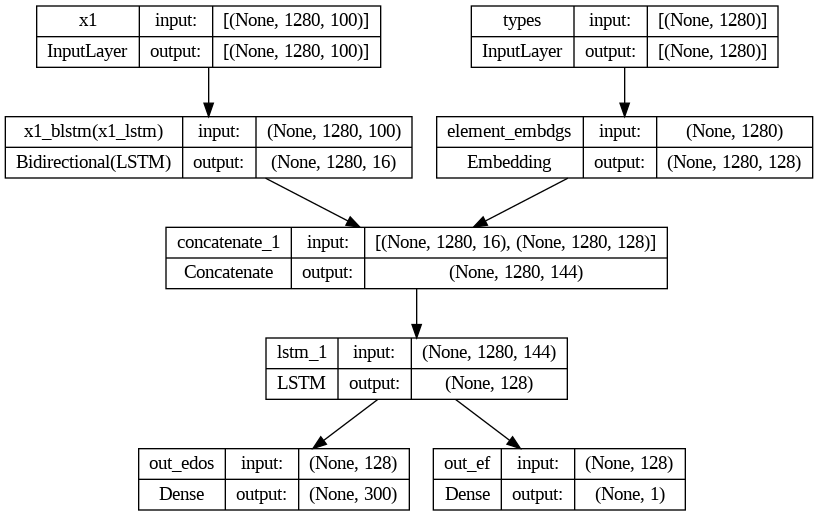

In [34]:
plot_model(model, show_shapes=True, show_layer_names=True,to_file=mname+".png")

In [35]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x1 (InputLayer)                [(None, 1280, 100)]  0           []                               
                                                                                                  
 types (InputLayer)             [(None, 1280)]       0           []                               
                                                                                                  
 x1_blstm (Bidirectional)       (None, 1280, 16)     6976        ['x1[0][0]']                     
                                                                                                  
 element_embdgs (Embedding)     (None, 1280, 128)    12032       ['types[0][0]']                  
                                                                                            

In [36]:
model.compile(loss ='mae',
              optimizer= keras.optimizers.Adam(learning_rate=config.LR),
              metrics='mse')

In [ ]:
def scheduler(epoch):
    initial_lrate = config.LR
    drop = 0.92
    epochs_drop = 5
    lr = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    if lr<0.0001:
        lr = 0.0001
    return lr

epochs=50*config.BATCH_SIZE
initEp=0
csv_logger = tf.keras.callbacks.CSVLogger(mname+"_log.csv", append=True)
earlyStopping= tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, min_delta=0.01)
checkpoint = tf.keras.callbacks.ModelCheckpoint(mname+".h5",verbose=2,monitor='val_loss', mode='min',save_freq=5000)
callbacks_list = [checkpoint,csv_logger,earlyStopping,tf.keras.callbacks.LearningRateScheduler(scheduler)]
for _ in range(5):
  hist = model.fit(x=[x1t,x3t],y = [ytrain,y2],validation_data = ([x1v, x3v],[ytrainv,y2v]),
                   initial_epoch = initEp, epochs = epochs,batch_size = config.BATCH_SIZE,callbacks = callbacks_list, verbose=1)
  initEp=initEp+epochs

model.save(mname+".h5")

Epoch 1/50
708/708 [==============================] - 30s 42ms/step - loss: 5.1251 - out_edos_loss: 5.0296 - out_ef_loss: 0.0955 - out_edos_mse: 231.0887 - out_ef_mse: 0.0174 - val_loss: 4.6417 - val_out_edos_loss: 4.5353 - val_out_ef_loss: 0.1065 - val_out_edos_mse: 292.2986 - val_out_ef_mse: 0.0153 - lr: 0.0010
Epoch 2/50
708/708 [==============================] - 29s 41ms/step - loss: 5.8174 - out_edos_loss: 5.7265 - out_ef_loss: 0.0909 - out_edos_mse: 333.0777 - out_ef_mse: 0.0163 - val_loss: 4.9351 - val_out_edos_loss: 4.8522 - val_out_ef_loss: 0.0829 - val_out_edos_mse: 351.5615 - val_out_ef_mse: 0.0108 - lr: 0.0010
Epoch 3/50
708/708 [==============================] - 31s 44ms/step - loss: 5.1808 - out_edos_loss: 5.0853 - out_ef_loss: 0.0954 - out_edos_mse: 271.9915 - out_ef_mse: 0.0173 - val_loss: 5.7000 - val_out_edos_loss: 5.6250 - val_out_ef_loss: 0.0749 - val_out_edos_mse: 364.2024 - val_out_ef_mse: 0.0095 - lr: 0.0010
Epoch 4/50
708/708 [==============================] - 2

In [44]:
preds = model.predict([x1,x3],batch_size = 256)

4/4 [==============================] - 1s 132ms/step


In [45]:
dbresults={}
dbresults['x4'] = dbedos['x4']
dbresults['y'] = dbedos['y']
dbresults['preds'] = preds[0]
dbresults['train_idx'] = trainidx
dbresults['validate_idx'] = validx 
dbresults['test_idx'] = testidx
dbresults['formula'] = dbedos['formula']
dbresults['ids'] = dbedos['ids']

In [46]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,median_absolute_error
ytest    = dbresults['y'][testidx]
x4test      = dbresults['x4']
predtest = dbresults['preds'][testidx]
msev = np.asarray([mean_squared_error(i,j) for i,j in zip(ytest,predtest)])
maev = np.asarray([mean_absolute_error(i,j) for i,j in zip(ytest,predtest)])
mseV=np.mean(msev)
maeV=np.mean(maev)
print(mseV,maeV)

2482.089720136729 10.734587548508133


mean_squared_error:  7.775627879174652
mean_absolute_error:  1.552533374429639


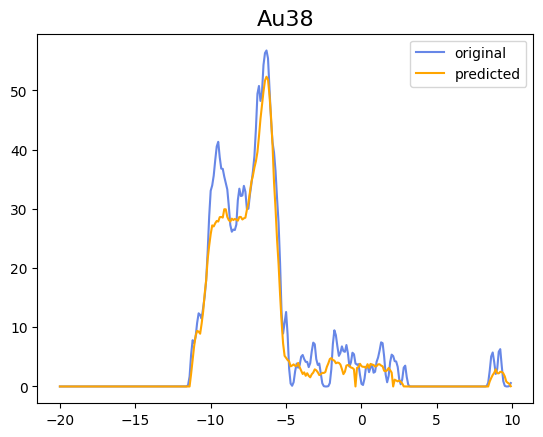

In [42]:
p = np.random.permutation(np.where(msev>0)[0])
ind=np.random.randint(len(msev))
ft=[formula[i] for i in testidx]
y_true = ytest[ind]
y_pred = predtest[ind]
plt.plot(x4test,y_true,'royalblue',label='original',alpha=0.8)
plt.plot(x4test,y_pred,'orange',label='predicted')
plt.title(ft[ind], fontsize=16)
print('mean_squared_error: ',mean_squared_error(y_true,y_pred))
print('mean_absolute_error: ',mean_absolute_error(y_true,y_pred))
plt.legend();